In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# set the directory containing the images
dir_path = "/content/gdrive/MyDrive/thinkAI_dataset"

# set the target size
target_size = (512, 512)

# loop over all images in the directory
for filename in os.listdir(dir_path):
    if filename.split('.')[-1] in ('jpg', 'jpeg', 'png'):
        # open the image file
        img = Image.open(os.path.join(dir_path, filename))

        # resize the image
        img = img.resize(target_size, resample=Image.LANCZOS)

        # save the resized image
        img.save(os.path.join(dir_path, filename))


In [ ]:
from PIL import Image
import os

In [ ]:
%pip install -qqU diffusers transformers bitsandbytes accelerate ftfy datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="/content/gdrive/MyDrive/thinkAI_dataset")
# Remove the dummy label column
# dataset = dataset.remove_columns("label")
# Push to Hub
dataset.push_to_hub("dreambooth-moroccan-design")

Resolving data files:   0%|          | 0/47 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-9a6949866a16048d/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from datasets import load_dataset

dataset_id = "medmac01/dreambooth-moroccan-design"
dataset = load_dataset(dataset_id, split="train")
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/47 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/medmac01___parquet/medmac01--dreambooth-moroccan-design-221b649727c4daaa/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Dataset({
    features: ['image'],
    num_rows: 47
})

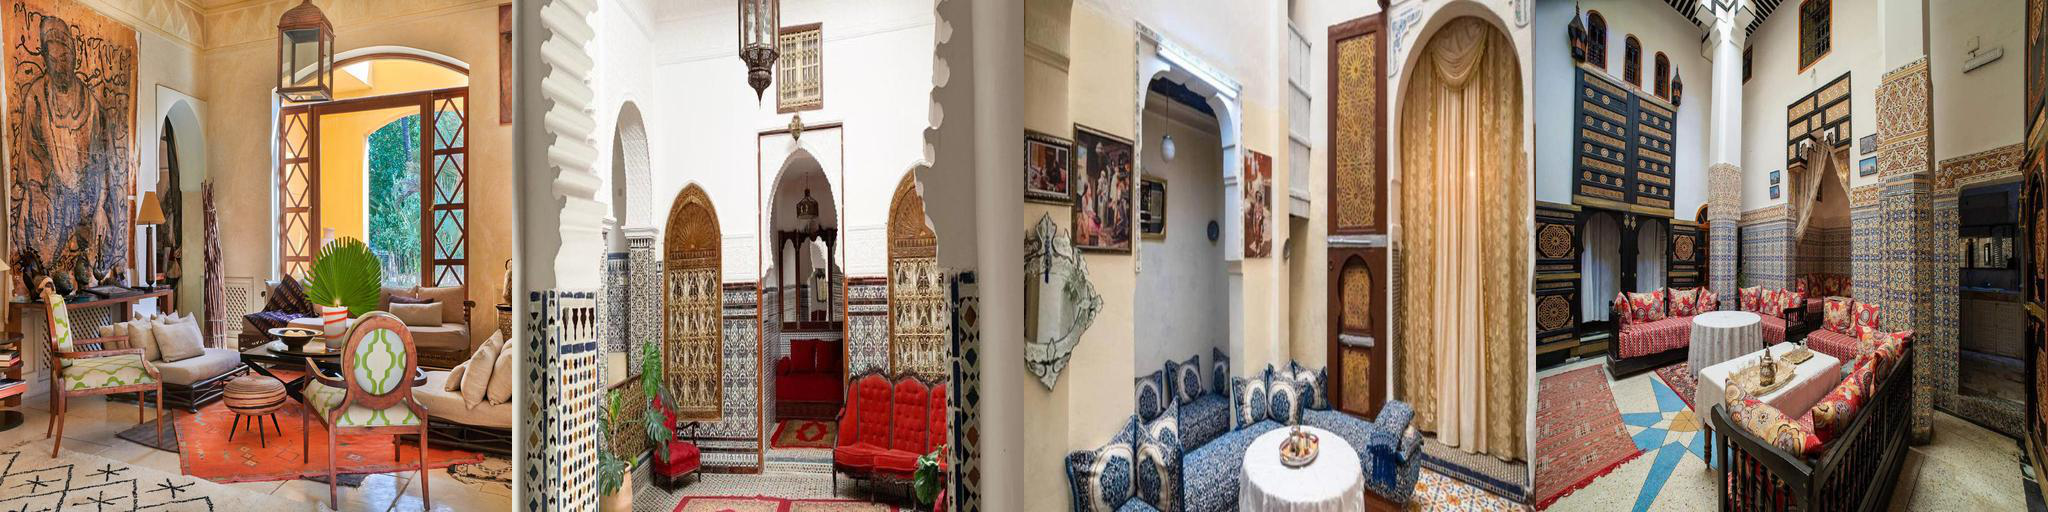

In [ ]:
from PIL import Image


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


num_samples = 4
image_grid(dataset["image"][:num_samples], rows=1, cols=num_samples)

##Step 3: Create a training dataset

In [ ]:
name_of_your_concept = "beldi"  # CHANGE THIS ACCORDING TO YOUR SUBJECT
type_of_thing = "moroccan interiour"  # CHANGE THIS ACCORDING TO YOUR SUBJECT
instance_prompt = f"a photo of {name_of_your_concept} {type_of_thing}"
print(f"Instance prompt: {instance_prompt}")

Instance prompt: a photo of beldi moroccan interiour


In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms


class DreamBoothDataset(Dataset):
    def __init__(self, dataset, instance_prompt, tokenizer, size=512):
        self.dataset = dataset
        self.instance_prompt = instance_prompt
        self.tokenizer = tokenizer
        self.size = size
        self.transforms = transforms.Compose(
            [
                transforms.Resize(size),
                transforms.CenterCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        example = {}
        image = self.dataset[index]["image"]
        example["instance_images"] = self.transforms(image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids
        return example

In [ ]:
from transformers import CLIPTokenizer

# The Stable Diffusion checkpoint we'll fine-tune
model_id = "CompVis/stable-diffusion-v1-4"
tokenizer = CLIPTokenizer.from_pretrained(
    model_id,
    subfolder="tokenizer",
)

train_dataset = DreamBoothDataset(dataset, instance_prompt, tokenizer)
# train_dataset[0]

In [ ]:
import torch


def collate_fn(examples):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]
    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = tokenizer.pad(
        {"input_ids": input_ids}, padding=True, return_tensors="pt"
    ).input_ids

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
    }
    return batch

In [ ]:
from diffusers import AutoencoderKL, UNet2DConditionModel
from transformers import CLIPFeatureExtractor, CLIPTextModel

text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
feature_extractor = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


## Step 6: Fine-tune the model

In [ ]:
learning_rate = 2e-06
max_train_steps = 400

Next, let's wrap the other hyperparameters we need in a `Namespace` object to make it easier to configure the training run:

In [ ]:
from argparse import Namespace

args = Namespace(
    pretrained_model_name_or_path=model_id,
    resolution=512, # Reduce this if you want to save some memory
    train_dataset=train_dataset,
    instance_prompt=instance_prompt,
    learning_rate=learning_rate,
    max_train_steps=max_train_steps,
    train_batch_size=1,
    gradient_accumulation_steps=1, # Increase this if you want to lower memory usage
    max_grad_norm=1.0,
    gradient_checkpointing=True,  # set this to True to lower the memory usage.
    use_8bit_adam=True,  # use 8bit optimizer from bitsandbytes
    seed=3434554,
    sample_batch_size=2,
    output_dir="my-dreambooth",  # where to save the pipeline
)

In [ ]:
import math

import torch.nn.functional as F
from accelerate import Accelerator
from accelerate.utils import set_seed
from diffusers import DDPMScheduler, PNDMScheduler, StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from torch.utils.data import DataLoader
from tqdm.auto import tqdm


def training_function(text_encoder, vae, unet):

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
    )

    set_seed(args.seed)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        import bitsandbytes as bnb
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    optimizer = optimizer_class(
        unet.parameters(),  # only optimize unet
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler(
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        num_train_timesteps=1000,
    )

    train_dataloader = DataLoader(
        args.train_dataset,
        batch_size=args.train_batch_size,
        shuffle=True,
        collate_fn=collate_fn,
    )

    unet, optimizer, train_dataloader = accelerator.prepare(
        unet, optimizer, train_dataloader
    )

    # Move text_encode and vae to gpu
    text_encoder.to(accelerator.device)
    vae.to(accelerator.device)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(
        len(train_dataloader) / args.gradient_accumulation_steps
    )
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = (
        args.train_batch_size
        * accelerator.num_processes
        * args.gradient_accumulation_steps
    )
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(
        range(args.max_train_steps), disable=not accelerator.is_local_main_process
    )
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
                    latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0,
                    noise_scheduler.config.num_train_timesteps,
                    (bsz,),
                    device=latents.device,
                ).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(
                    noisy_latents, timesteps, encoder_hidden_states
                ).sample
                loss = (
                    F.mse_loss(noise_pred, noise, reduction="none")
                    .mean([1, 2, 3])
                    .mean()
                )

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()

    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        print(f"Loading pipeline and saving to {args.output_dir}...")
        scheduler = PNDMScheduler(
            beta_start=0.00085,
            beta_end=0.012,
            beta_schedule="scaled_linear",
            skip_prk_steps=True,
            steps_offset=1,
        )
        pipeline = StableDiffusionPipeline(
            text_encoder=text_encoder,
            vae=vae,
            unet=accelerator.unwrap_model(unet),
            tokenizer=tokenizer,
            scheduler=scheduler,
            safety_checker=StableDiffusionSafetyChecker.from_pretrained(
                "CompVis/stable-diffusion-safety-checker"
            ),
            feature_extractor=feature_extractor,
        )
        pipeline.save_pretrained(args.output_dir)

Now that we have the function defined, let's train it! Depending on the size of your dataset and type of GPU, this can take anywhere from 5 minutes to 1 hour to run:

In [ ]:
from accelerate import notebook_launcher

num_of_gpus = 1
notebook_launcher(
    training_function, args=(text_encoder, vae, unet), num_processes=num_of_gpus
)

/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('http'), PosixPath('//172.28.0.1'), PosixPath('8013')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//colab.research.google.com/tun/m/cc483011

Launching training on one GPU.

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


  0%|          | 0/400 [00:00<?, ?it/s]

Loading pipeline and saving to my-dreambooth...


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

## Step 7: Run inference and inspect generations

Now that we've trained the model, let's generate some images with it to see how it fares! First we'll load the pipeline from the output directory we save the model to:

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(
    args.output_dir,
    torch_dtype=torch.float16,
).to("cuda")

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

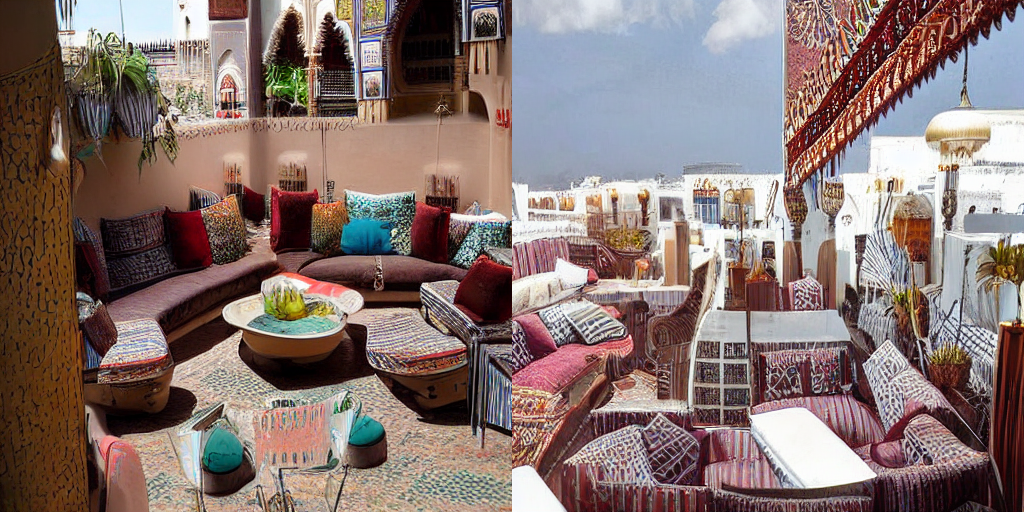

In [ ]:
# Pick a funny prompt here and it will be used as the widget's default 
# when we push to the Hub in the next section
prompt = f"a photo of a {name_of_your_concept} {type_of_thing} in a rooftop space"

# Tune the guidance to control how closely the generations follow the prompt.
# Values between 7-11 usually work best
guidance_scale = 7

num_cols = 2
all_images = []
for _ in range(num_cols):
    images = pipe(prompt, guidance_scale=guidance_scale).images
    all_images.extend(images)

image_grid(all_images, 1, num_cols)

In [ ]:
print(prompt)

a photo of beldi moroccan interiour a souk


## Step 8: Push your model to the Hub

In [ ]:
# Create a name for your model on the Hub. No spaces allowed.
model_name = f"{name_of_your_concept}-{type_of_thing}"

Next, add a brief description on the type of model you've trained or any other information you'd like to share:

In [ ]:
# Describe the theme and model you've trained
description = f"""
This is a Stable Diffusion model fine-tuned on `{type_of_thing}` images .
"""

Finally, run the cell below to create a repo on the Hub and push all our files with a nice model card to boot:

In [ ]:
# Code to upload a pipeline saved locally to the hub
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

# Set up repo and upload files
hub_model_id = "medmac01/beldimoroccaninteriour"
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(folder_path=args.output_dir, path_in_repo="", repo_id=hub_model_id)

content = f"""
---
license: creativeml-openrail-m
tags:
- pytorch
- diffusers
- stable-diffusion
- text-to-image
- diffusion-models-class
- dreambooth-hackathon
- {theme}
widget:
- text: {prompt}
---

# DreamBooth model for the {name_of_your_concept} concept trained by {api.whoami()["name"]} on the {dataset_id} dataset.

This is a Stable Diffusion model fine-tuned on the {name_of_your_concept} concept with DreamBooth. It can be used by modifying the `instance_prompt`: **{instance_prompt}**

This model was created as part of the DreamBooth Hackathon 🔥. Visit the [organisation page](https://huggingface.co/dreambooth-hackathon) for instructions on how to take part!

## Description

{description}

## Usage

```python
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
hub_url = card.push_to_hub(hub_model_id)
print(f"Upload successful! Model can be found here: {hub_url}")
print(
    f"View your submission on the public leaderboard here: https://huggingface.co/spaces/dreambooth-hackathon/leaderboard"
)

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 10>:20                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'theme' is not defined